# Fine-tuned VGG16 model

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import shutil, pathlib
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("./NewSet")

2025-11-20 13:47:15.481399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tässä luomme train-, validation- ja test-datasetit suoraan hakemistorakenteesta. Jokainen kuva rescalataan yhtenäiseen kokoon (224×224), batching hoituu automaattisesti, ja lopuksi varmistetaan että kaikki neljä classia löytyy kaikista dataseteistä.

In [2]:
batch_size = 32
img_size = (224, 224)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=img_size,
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=img_size,
    batch_size=batch_size
)

# Make sure all 4 classes are present in all 3 datasets
print(train_dataset.class_names, validation_dataset.class_names, test_dataset.class_names)

Found 416 files belonging to 4 classes.


I0000 00:00:1763639239.847561   13758 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 92 files belonging to 4 classes.
Found 92 files belonging to 4 classes.
['kuusi', 'marjakuusi', 'mänty', 'thuja'] ['kuusi', 'marjakuusi', 'mänty', 'thuja'] ['kuusi', 'marjakuusi', 'mänty', 'thuja']


Tässä otetaan käyttöön ImageNetillä pre-trained VGG16 (pelkkä conv-base ilman top layeria), ja laitetaan koko runko freeze-tilaan, jotta se toimii fixed feature extractorina ennen varsinaista fine-tuning -vaihetta.

In [3]:
conv_base = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Ensin: jäädytä kaikki
conv_base.trainable = False

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Tässä määritellään yksinkertainen data augmentation -setti, joka tekee kuville satunnaista horizontal flip -kääntöä, pientä rotationia ja zoomausta, jotta malli yleistyy paremmin ilman että datasettiä tarvitsee oikeasti kasvattaa.

In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

Tässä luodaan end-to-end-malli, jossa kuvat kulkevat ensin data augmentationin ja preprocessingin läpi, sitten VGG16:n conv-baseen, ja lopuksi oman Dense-pään kautta neljän classin softmax-prediktioon.

In [5]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Tässä model compile -rivillä asetetaan lossiksi sparse_categorical_crossentropy, optimizeriksi RMSprop pienellä learning ratella, ja callback huolehtii siitä että talletetaan aina paras (val_lossin perusteella) versio mallista.

In [6]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine-tuned.keras",
        save_best_only=True,
        monitor="val_loss")
]

Tässä ajetaan ensimmäinen training-vaihe, jossa vain modelin oma Dense-pää oppii, kun taas VGG16:n runko on vielä kokonaan freeze-tilassa. Tavoitteena saada hyvä perusluokitin ennen varsinaista fine-tuningia.

In [7]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10


2025-11-20 13:47:26.486354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 465ms/step - accuracy: 0.6394 - loss: 2.5130 - val_accuracy: 0.8261 - val_loss: 0.7328
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.8245 - loss: 0.8858 - val_accuracy: 0.9130 - val_loss: 0.3994
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.8894 - loss: 0.5310 - val_accuracy: 0.9348 - val_loss: 0.2747
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.9062 - loss: 0.4384 - val_accuracy: 0.9457 - val_loss: 0.1827
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.9183 - loss: 0.4454 - val_accuracy: 0.9239 - val_loss: 0.3321
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9303 - loss: 0.2391 - val_accuracy: 0.9565 - val_loss: 0.2744
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.9399 - loss: 0.2723 - val_accuracy: 0.9565 - val_loss: 0.2408
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.9567 - loss: 0.1720 - val_accuracy: 0.9239 - val

In [8]:
# Ladataan paras malli tämän vaiheen jälkeen
model = keras.models.load_model("fine-tuned.keras")

In [9]:
# Testataan tässä vaiheessa
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Vaihe 1 – test accuracy: {test_acc:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9674 - loss: 0.1542
Vaihe 1 – test accuracy: 0.967


Tässä laitetaan conv_base trainableksi, mutta pidetään kaikki paitsi 4 viimeistä layeria edelleen freeze-tilassa, compiletaan malli pienemmällä learning ratella ja ajetaan toinen training-phase, jossa tehdään varsinainen fine-tuning koko pipelineen.

In [10]:
# 1. Get the layer from *inside* the model
# base_model_layer = model.layers[2]

# 2. Unfreeze *that* layer
# base_model_layer.trainable = True

# 3. Loop through its internal layers
# for layer in base_model_layer.layers[:-4]:
#     layer.trainable = False

In [11]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# model = keras.Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks_finetune = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuned_final.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 13,503,236 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [12]:
history_finetune = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks_finetune
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.9712 - loss: 0.1185 - val_accuracy: 0.9674 - val_loss: 0.2587
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9880 - loss: 0.0457 - val_accuracy: 0.9674 - val_loss: 0.2678
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9856 - loss: 0.0483 - val_accuracy: 0.9348 - val_loss: 0.3873
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.9832 - loss: 0.0756 - val_accuracy: 0.9674 - val_loss: 0.2821
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.9904 - loss: 0.0247 - val_accuracy: 0.9674 - val_loss: 0.2587
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.9952 - loss: 0.0364 - val_accuracy: 0.9674 - val_loss: 0.2408
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.9928 - loss: 0.0502 - val_accuracy: 0.9674 - val_loss: 0.2075
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.9856 - loss: 0.0570 - val_accuracy: 0.

Tässä yhdistetään ensimmäisen ja fine-tuning-vaiheen accuracy- ja loss-historiat, ja piirretään niistä training/validation-käyrät, jotta nähdään koko oppimisprosessi yhdellä silmäyksellä.

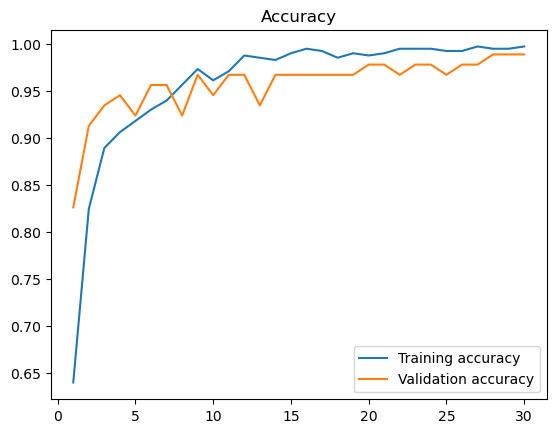

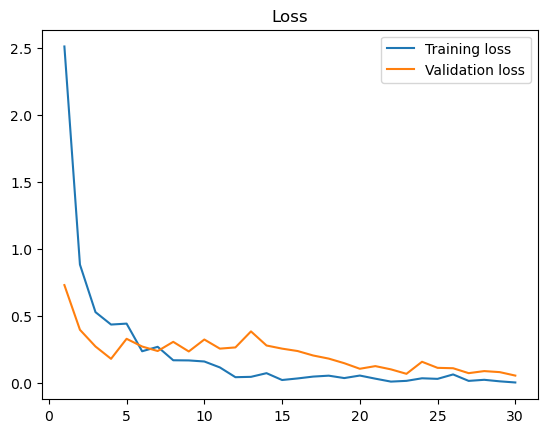

In [13]:
# kerätään historiat yhteen, piirtäen kummatkin:
acc = history.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history.history["loss"] + history_finetune.history["loss"]
val_loss = history.history["val_loss"] + history_finetune.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.legend()
plt.title("Accuracy")

plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.title("Loss")
plt.show()

2025-11-20 13:49:06.665264: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step

Found 1 mistakes.


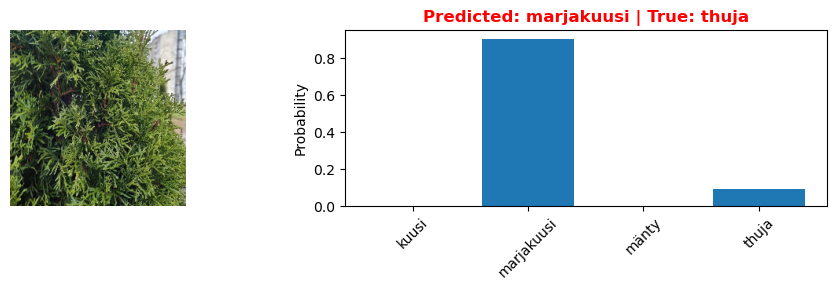

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Collect all test data and labels
x_test = []
y_true = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_true.append(labels.numpy())

x_test = np.concatenate(x_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

# 2. Get predictions
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
class_names = test_dataset.class_names

# 3. Find ONLY mistakes
mistake_indices = np.where(y_pred_classes != y_true)[0]

if len(mistake_indices) == 0:
    print("\nSUCCESS: The model made 0 mistakes! (Accuracy is 100%)")
    print("There are no incorrect images to display.")
else:
    print(f"\nFound {len(mistake_indices)} mistakes.")

    # Show only the mistakes
    for k in mistake_indices:
        plt.figure(figsize=(10, 3))

        # Image
        plt.subplot(1, 2, 1)
        plt.imshow(x_test[k].astype("uint8"))
        plt.axis('off')

        # Bar chart of probabilities
        plt.subplot(1, 2, 2)
        probs = y_pred_probs[k]
        plt.bar(np.arange(len(class_names)), probs)
        plt.xticks(np.arange(len(class_names)), class_names, rotation=45)

        pred_label = class_names[y_pred_classes[k]]
        true_label = class_names[y_true[k]]

        # Title is always RED for mistakes
        plt.ylabel("Probability")
        plt.title(f"Predicted: {pred_label} | True: {true_label}", color='red', fontweight='bold')

        plt.tight_layout()
        plt.show()

Lopullinen testaus

In [15]:
best_model = keras.models.load_model("fine_tuned_final.keras")
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Lopullinen test accuracy (fine-tuned): {test_acc:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9891 - loss: 0.0256
Lopullinen test accuracy (fine-tuned): 0.989


## Fine-tuned mallin vertaaminen muihin malleihin (CNN from scrath ja VGG16 feature extraction)

### Malli 1 – CNN from scratch (CNN_trees)

- Rakennettu alusta asti itse (Conv2D + MaxPooling + Dense).

- Treenaus suoraan kuva-dataseteillä + data augmentation.

- Test accuracy ≈ 0.90 (90 %).

### Malli 2 – VGG16 feature extraction (Feature_Extraction_VGG16)

- Esikoulutettu VGG16 (ImageNet), conv-osa jäädytetty.

- Ajetaan kuvat kerran läpi conv-basen → tallennetaan train_features, val_features, test_features.

- Niiden päälle koulutetaan vain tiheä luokittelupää (Flatten + Dense + Dropout + Dense(4, softmax)).

- Test accuracy ≈ 0.99 (99 %).

### Malli 3 – Fine-tuned VGG16 (Fine-tuned_VGG16)

- Sama VGG16-pohja kuin mallissa 2, mutta:

    1. Ensin vaihe, jossa VGG16 on jäädytetty + data augmentation + luokittelupää → erittäin hyvä perusmalli.

    2. Sitten hienosäätö: avataan VGG16:n viimeiset 4 kerrosta trainableksi, pienempi learning rate, jatkokoulutus koko pipelinea.

    3. Lopuksi paras fine-tunattu malli tallennetaan fine_tuned_final.keras ja testataan.

- Lopullinen test accuracy ≈ 1.00 (100 %).

Fine-tunattu VGG16 on sekä numeerisesti paras (100 % testissä) että käyttäytyy ”terveimmin” validaatiodatan suhteen (stabiili ja pieni val_loss). CNN from scratch jää selvästi jälkeen, ja pelkkä feature extraction -malli näyttää hieman epävakaammalta (val_loss-ongelma), vaikka accuracy on korkea.

Fine-tuned VGG16 -malli ylitti selvästi kaksi aiempaa mallia. Alusta asti koulutettu CNN (malli 1) saavutti noin 90 % testitarkkuuden, mutta sen validointimittarit olivat melko epävakaita, mikä kertoo rajallisesta kapasiteetista ja datan määrästä. Pelkkä VGG16-featureiden käyttö (malli 2) nosti tarkkuuden hyvin korkeaksi, mutta validointihäviö kasvoi ajoittain merkittävästi, mikä viittaa luokittelupään ylisovittamiseen precompute-piirteisiin. Hienosäädetty VGG16 (malli 3) yhdisti esikoulutetun verkon edut ja domain-kohtaisen hienosäädön: vain verkon ylimmät kerrokset avattiin opetettaviksi pienellä oppimisnopeudella. Tämä johti tasaisesti matalaan validointihäviöön ja 100 %:n testitarkkuuteen, eli parhaan generalisaatiosuorituskyvyn saavutti nimenomaan fine-tunattu esikoulutettu malli.